In [107]:
import jsonlines
import numpy as np
import spacy

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt

from scicite.compute_features import get_formulaic_features, get_agent_features

In [2]:
ACLARC_TEST = "scicite/data/acl-arc/test.jsonl"
ACLARC_DEV = "scicite/data/acl-arc/dev.jsonl"
ACLARC_TRAIN = "scicite/data/acl-arc/train.jsonl"

SCICITE_TEST_OLD = "scicite/data/scicite/test.jsonl"
SCICITE_DEV_OLD = "scicite/data/scicite/dev.jsonl"
SCICITE_TRAIN_OLD = "scicite/data/scicite/train.jsonl"

SCICITE_TEST_NEW = "scicite/data/scicite-upd/test.jsonl"
SCICITE_DEV_NEW = "scicite/data/scicite-upd/dev.jsonl"
SCICITE_TRAIN_NEW = "scicite/data/scicite-upd/train.jsonl"

***CREATE NEW DATASET***

In [16]:
nlp = spacy.load("en_core_web_sm")

In [17]:
def process_sentence(sent: str):
    doc = nlp(sent)
    #print("Doc=", doc)
    token_list = []
    for i, token in enumerate(doc):
        cur_token = {
            'index': token.i + 1,
            'word': token.text,
            'lemma': token.lemma_,
            'pos': token.tag_,
            'originalText': token.text,
            'ArgType': token.dep_,

        }
        token_list.append(cur_token)
        #print("Token:")
        #print(token.i, token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #            token.shape_, token.is_alpha, token.is_stop)
    return token_list

In [19]:
def create_new_dataset():
    
    with jsonlines.open(SCICITE_TEST_OLD, 'r') as reader:
        with jsonlines.open(SCICITE_TEST_NEW, 'w') as writer:
            for item in enumerate(reader):
                item[1]['text'] = process_sentence(item[1]['string'])
                writer.write(item[1])
    print("done_test")
                
    with jsonlines.open(SCICITE_DEV_OLD, 'r') as reader:
        with jsonlines.open(SCICITE_DEV_NEW, 'w') as writer:
            for item in enumerate(reader):
                item[1]['text'] = process_sentence(item[1]['string'])
                writer.write(item[1])
    print("done_dev")
                
    with jsonlines.open(SCICITE_TRAIN_OLD, 'r') as reader:
        with jsonlines.open(SCICITE_TRAIN_NEW, 'w') as writer:
            for item in enumerate(reader):
                item[1]['text'] = process_sentence(item[1]['string'])
                writer.write(item[1])

In [20]:
create_new_dataset()

done_test
done_dev


Example of acl-arc token:

{"index": 4, "word": "Bulgarian", "lemma": "bulgarian", "after": " ", "pos": "JJ", "characterOffsetEnd": 513, "segment_span": [0, 43], "characterOffsetBegin": 504, "originalText": "Bulgarian", "ArgType": "verb", "before": " "}

***CHECK SIMILARITY***

In [29]:
def compute_all_patterns_features(item):
    formulaic_features, fn_1, __ = get_formulaic_features(item['sents_before'][0], prefix='InCitSent:')
    agent_features, fn_2, _ = get_agent_features(item['sents_before'][0], prefix='InCitSent:')
    fn_3, fn_4 = [], []
    
    formulaic_clause_features = formulaic_features
    agent_clause_features = agent_features
    if len(item['sents_before']) > 1:
        for cur_sentence in item['sents_before'][1:]:
            _formulaic_features, fn_3, _ = get_formulaic_features(cur_sentence, prefix='InClause:')
            _agent_features, fn_4, _ = get_agent_features(cur_sentence, prefix='InClause:')
            formulaic_clause_features = [f_1 or f_2 for f_1, f_2 in zip(formulaic_clause_features,
                                                                        _formulaic_features)]
            agent_clause_features = [f_1 or f_2 for f_1, f_2 in zip(agent_clause_features,
                                                                    _agent_features)]
    for cur_sentence in item['sents_after']:
        _formulaic_features, _, _ = get_formulaic_features(cur_sentence, prefix='InClause:')
        _agent_features, _, _ = get_agent_features(cur_sentence, prefix='InClause:')
        formulaic_clause_features = [f_1 or f_2 for f_1, f_2 in zip(formulaic_clause_features,
                                                                    _formulaic_features)]
        agent_clause_features = [f_1 or f_2 for f_1, f_2 in zip(agent_clause_features,
                                                                _agent_features)]
        

    x = formulaic_features + agent_features + formulaic_clause_features + agent_clause_features 
    y = CLASSES.index(item['intent'])
    feature_names = fn_1 + fn_2
    if fn_3:
        feature_names += fn_3 + fn_4 
    return x, y, feature_names

In [30]:
def compute_aclarc_features(item):
    formulaic_features, fn_1, __ = get_formulaic_features(item['sents_before'][0], prefix='InCitSent:')
    agent_features, fn_2, _ = get_agent_features(item['sents_before'][0], prefix='InCitSent:')

    x = formulaic_features + agent_features
    y = 0
    return x, y

In [31]:
def compute_scicite_features(item):
    formulaic_features, fn_1, __ = get_formulaic_features(item['text'], prefix='InCitSent:')
    agent_features, fn_2, _ = get_agent_features(item['text'], prefix='InCitSent:')

    x = formulaic_features + agent_features
    y = 1
    return x, y

In [35]:
def get_aclarc_data():
    X = []
    y = []
    
    with jsonlines.open(ACLARC_TEST, 'r') as reader:
        for item in enumerate(reader):
            _x, _y = compute_aclarc_features(item[1])
            X.append(_x)
            y.append(_y)
    print("done test")
    
    with jsonlines.open(ACLARC_DEV, 'r') as reader:
        for item in enumerate(reader):
            _x, _y = compute_aclarc_features(item[1])
            X.append(_x)
            y.append(_y)
    print("done dev")
        
    with jsonlines.open(ACLARC_TRAIN, 'r') as reader:
        for item in enumerate(reader):
            _x, _y = compute_aclarc_features(item[1])
            X.append(_x)
            y.append(_y)
    print("done train")
    
    return X, y

In [36]:
X_aclarc, y_aclarc = get_aclarc_data()

done test
done dev
done train


In [37]:
def get_scicite_data():
    X = []
    y = []
    
    with jsonlines.open(SCICITE_TEST_NEW, 'r') as reader:
        for item in enumerate(reader):
            _x, _y = compute_scicite_features(item[1])
            X.append(_x)
            y.append(_y)
    print("done test")
    
    with jsonlines.open(SCICITE_DEV_NEW, 'r') as reader:
        for item in enumerate(reader):
            _x, _y = compute_scicite_features(item[1])
            X.append(_x)
            y.append(_y)
    print("done dev")
        
    with jsonlines.open(SCICITE_TRAIN_NEW, 'r') as reader:
        for item in enumerate(reader):
            _x, _y = compute_scicite_features(item[1])
            X.append(_x)
            y.append(_y)
    print("done train")
    
    return X, y

In [38]:
X_scicite, y_scicite = get_scicite_data()

done test
done dev
done train


Concat datasets

In [53]:
X_aclarc = np.array(X_aclarc)
y_aclarc = np.array(y_aclarc)
X_scicite = np.array(X_scicite)
y_scicite = np.array(y_scicite)

In [54]:
len(X_aclarc), len(y_aclarc), len(X_scicite), len(y_scicite)

(1941, 1941, 11020, 11020)

In [55]:
X = np.concatenate((X_aclarc, X_scicite))
y = np.concatenate((y_aclarc, y_scicite))

In [56]:
len(X), len(y)

(12961, 12961)

Shuffle

In [58]:
p = np.random.permutation(len(X))
X = X[p]
y = y[p]

In [64]:
clf = LGBMClassifier()
scores = cross_val_score(clf, X, y, scoring='f1', cv=5)
scores.mean()

0.924170185065013

In [74]:
clf = LGBMClassifier().fit(X, y)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

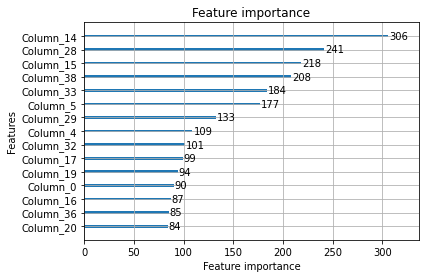

In [79]:
lgb.plot_importance(clf, max_num_features=15)

Create 'background' dataset

In [83]:
def compute_aclarc_features_back(item):
    formulaic_features, fn_1, __ = get_formulaic_features(item['sents_before'][0], prefix='InCitSent:')
    agent_features, fn_2, _ = get_agent_features(item['sents_before'][0], prefix='InCitSent:')

    x = formulaic_features + agent_features
    y = item['intent'] == 'Background'
    return x, y

In [84]:
def compute_scicite_features_back(item):
    formulaic_features, fn_1, __ = get_formulaic_features(item['text'], prefix='InCitSent:')
    agent_features, fn_2, _ = get_agent_features(item['text'], prefix='InCitSent:')

    x = formulaic_features + agent_features
    y = item['label'] == 'background'
    return x, y

In [88]:
def get_aclarc_data_back():
    X = []
    y = []
            
    with jsonlines.open(ACLARC_TRAIN, 'r') as reader:
        for item in enumerate(reader):
            _x, _y = compute_aclarc_features_back(item[1])
            X.append(_x)
            y.append(_y)
    print("done train")
    
    return X, y

In [89]:
X_aclarc_back, y_aclarc_back = get_aclarc_data_back()

done train


In [90]:
def get_scicite_data_back():
    X = []
    y = []
    
    with jsonlines.open(SCICITE_TEST_NEW, 'r') as reader:
        for item in enumerate(reader):
            _x, _y = compute_scicite_features_back(item[1])
            X.append(_x)
            y.append(_y)
    print("done test")
    
    with jsonlines.open(SCICITE_DEV_NEW, 'r') as reader:
        for item in enumerate(reader):
            _x, _y = compute_scicite_features_back(item[1])
            X.append(_x)
            y.append(_y)
    print("done dev")
        
    with jsonlines.open(SCICITE_TRAIN_NEW, 'r') as reader:
        for item in enumerate(reader):
            _x, _y = compute_scicite_features_back(item[1])
            X.append(_x)
            y.append(_y)
    print("done train")
    
    return X, y

In [91]:
X_scicite_back, y_scicite_back = get_scicite_data_back()

done test
done dev
done train


In [92]:
X_back = np.concatenate((X_aclarc_back, X_scicite_back))
y_back = np.concatenate((y_aclarc_back, y_scicite_back))

In [93]:
p_back = np.random.permutation(len(X_back))
X_back = X_back[p_back]
y_back = y_back[p_back]

In [94]:
clf_back = LGBMClassifier()
scores = cross_val_score(clf_back, X_back, y_back, scoring='f1', cv=5)
scores.mean()

0.7324557120051782

In [98]:
clf_back = LGBMClassifier().fit(X_back, y_back)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

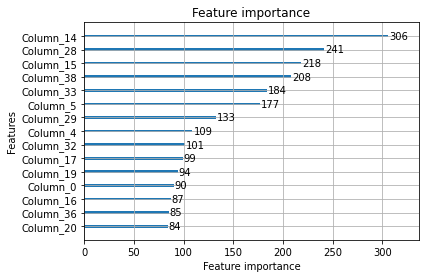

In [99]:
lgb.plot_importance(clf, max_num_features=15)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

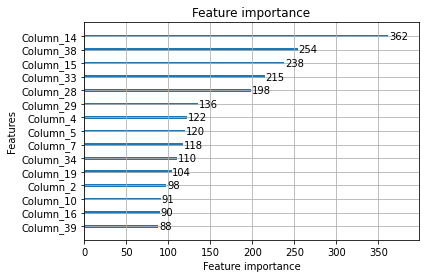

In [100]:
lgb.plot_importance(clf_back, max_num_features=15)

In [111]:
scicite_dict = np.array(X_scicite_back).astype(np.int32).sum(axis=0)
aclarc_dict = np.array(X_aclarc_back).astype(np.int32).sum(axis=0)

<BarContainer object of 56 artists>

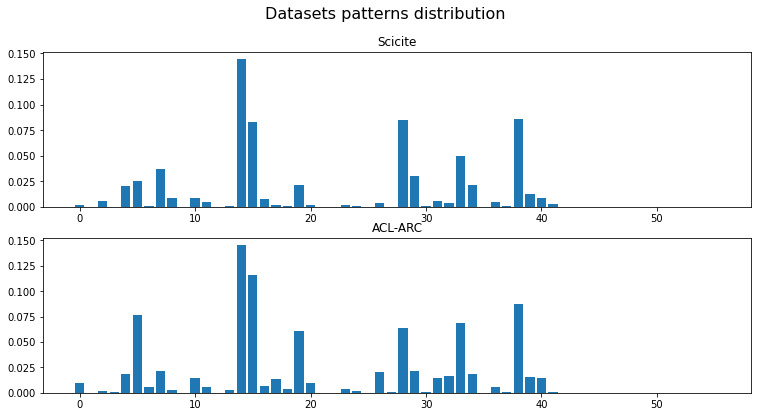

In [115]:
fig, ax = plt.subplots(2, 1, figsize=(12.7, 6.27))
fig.suptitle('Datasets patterns distribution', fontsize=16)

ax[0].set_title("Scicite")
ax[0].bar(range(56), scicite_dict/len(X_scicite_back))
                       
ax[1].set_title("ACL-ARC")
ax[1].bar(range(56), aclarc_dict/len(X_aclarc_back))

In [123]:
scicite_back_dict = np.array(X_scicite_back)[y_scicite_back].astype(np.int32).sum(axis=0)
aclarc_back_dict = np.array(X_aclarc_back)[y_aclarc_back].astype(np.int32).sum(axis=0)

<BarContainer object of 56 artists>

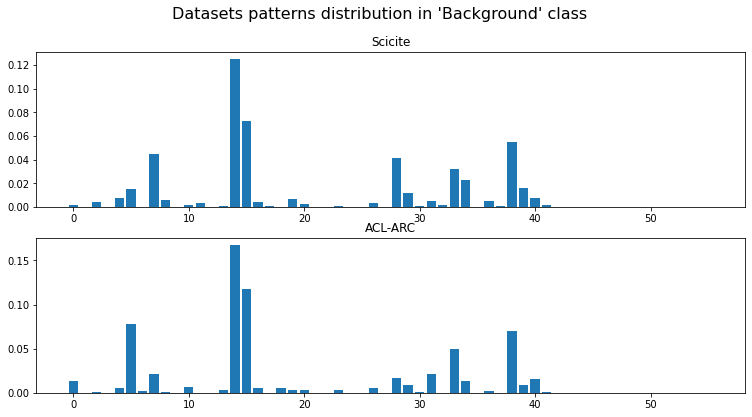

In [124]:
fig, ax = plt.subplots(2, 1, figsize=(12.7, 6.27))
fig.suptitle("Datasets patterns distribution in 'Background' class", fontsize=16)

ax[0].set_title("Scicite")
ax[0].bar(range(56), scicite_back_dict/len(np.array(X_scicite_back)[y_scicite_back]))
                       
ax[1].set_title("ACL-ARC")
ax[1].bar(range(56), aclarc_back_dict/len(np.array(X_aclarc_back)[y_aclarc_back]))